# Library Instalation 

In [ ]:
# !pip install -q imutils opencv-python-headless
# !pip install -q wandb ipywidgets

# Library Preparation

In [1]:
import os 
import tensorflow as tf 
import numpy as np
import zipfile as zf 
import seaborn as sns
import numpy as np
import pandas as pd
import wandb

from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
from PIL import Image
from tqdm import tqdm

In [2]:
import shutil
import matplotlib.pyplot as plt

from huggingface_hub import upload_folder
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from keras.applications.mobilenet import decode_predictions, preprocess_input

c:\Users\dzalh\Documents\MyData\magang\adamata\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load and Prepare Dataset

In [4]:
from datasets import load_dataset

dataset = load_dataset("garythung/trashnet", split='train')

README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

dataset-original.zip:   0%|          | 0.00/3.63G [00:00<?, ?B/s]

dataset-resized.zip:   0%|          | 0.00/42.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5054 [00:00<?, ? examples/s]

In [5]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 5054
})

In [6]:
dataset.features['label']

ClassLabel(names=['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'], id=None)

In [13]:
# Extract the images and labels from the dataset
data = dataset.to_pandas()
data['image_path'] = data['image'].apply(lambda x: x['path'])

classes = data['label'].unique()

In [18]:
# Define extraction folder for images
extract_to = "extracted_images"
if not os.path.exists(extract_to):
    os.makedirs(extract_to)

# Extract unique ZIP files
unique_zips = data['image_path'].apply(lambda x: x.split("::")[-1]).unique()
for zip_path in unique_zips:
    with zf.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Update image paths to point to extracted files
def update_path(row):
    relative_path = row['image_path'].split('::')[0].split('zip://')[-1]
    return os.path.join(extract_to, relative_path)

data['image_path'] = data.apply(update_path, axis=1)

Penjelasa Kode Ekstraksi
* Membuat folder extracted_images untuk menyimpan hasil ekstraksi.
* Mengekstrak file ZIP unik ke folder tersebut.
* Memperbarui image_path di dataset agar menunjuk ke file yang diekstrak.
  
Tujuan  
* Mempermudah akses gambar dari ZIP.
* Menghindari duplikasi ekstraksi.
* Mempercepat pengolahan data gambar.

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5054 entries, 0 to 5053
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5054 non-null   object
 1   label       5054 non-null   int64 
 2   image_path  5054 non-null   object
dtypes: int64(1), object(2)
memory usage: 118.6+ KB


In [12]:
data

image  label  \
0     {'bytes': None, 'path': 'zip://dataset-origina...      0   
1     {'bytes': None, 'path': 'zip://dataset-origina...      0   
2     {'bytes': None, 'path': 'zip://dataset-origina...      0   
3     {'bytes': None, 'path': 'zip://dataset-origina...      0   
4     {'bytes': None, 'path': 'zip://dataset-origina...      0   
...                                                 ...    ...   
5049  {'bytes': None, 'path': 'zip://dataset-resized...      5   
5050  {'bytes': None, 'path': 'zip://dataset-resized...      5   
5051  {'bytes': None, 'path': 'zip://dataset-resized...      5   
5052  {'bytes': None, 'path': 'zip://dataset-resized...      5   
5053  {'bytes': None, 'path': 'zip://dataset-resized...      5   

                                             image_path  
0     extracted_images/dataset-original/cardboard/ca...  
1     extracted_images/dataset-original/cardboard/ca...  
2     extracted_images/dataset-original/cardboard/ca...  
3     extracted_images/dataset-original/cardboard/ca...  
4     extracted_images/dataset-original/cardboard/ca...  
...                                                 ...  
5049  extracted_images/dataset-resized/trash/trash95...  
5050  extracted_images/dataset-resized/trash/trash96...  
5051  extracted_images/dataset-resized/trash/trash97...  
5052  extracted_images/dataset-resized/trash/trash98...  
5053  extracted_images/dataset-resized/trash/trash99...  

[5054 rows x 3 columns]

# Exploratory Image Analysis

## Class distribution analysis

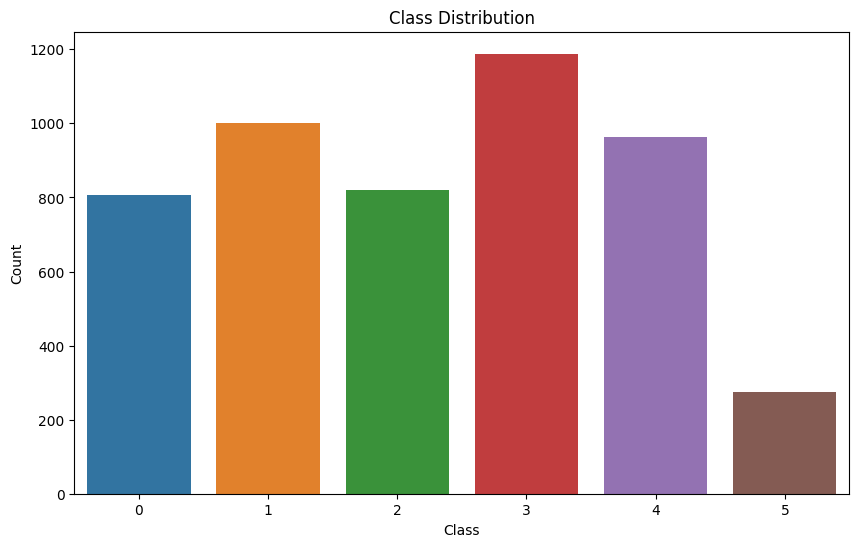

In [60]:
# Check the distribution of classes
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='label')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

Dari plot ini diketahui bahwa dataset trashnet ini merupakan dataset yang imbalance, hal ini diketahui dengan sangat menonjol pada total dataset dengan label **5 (trash)**

# Dataset Preview

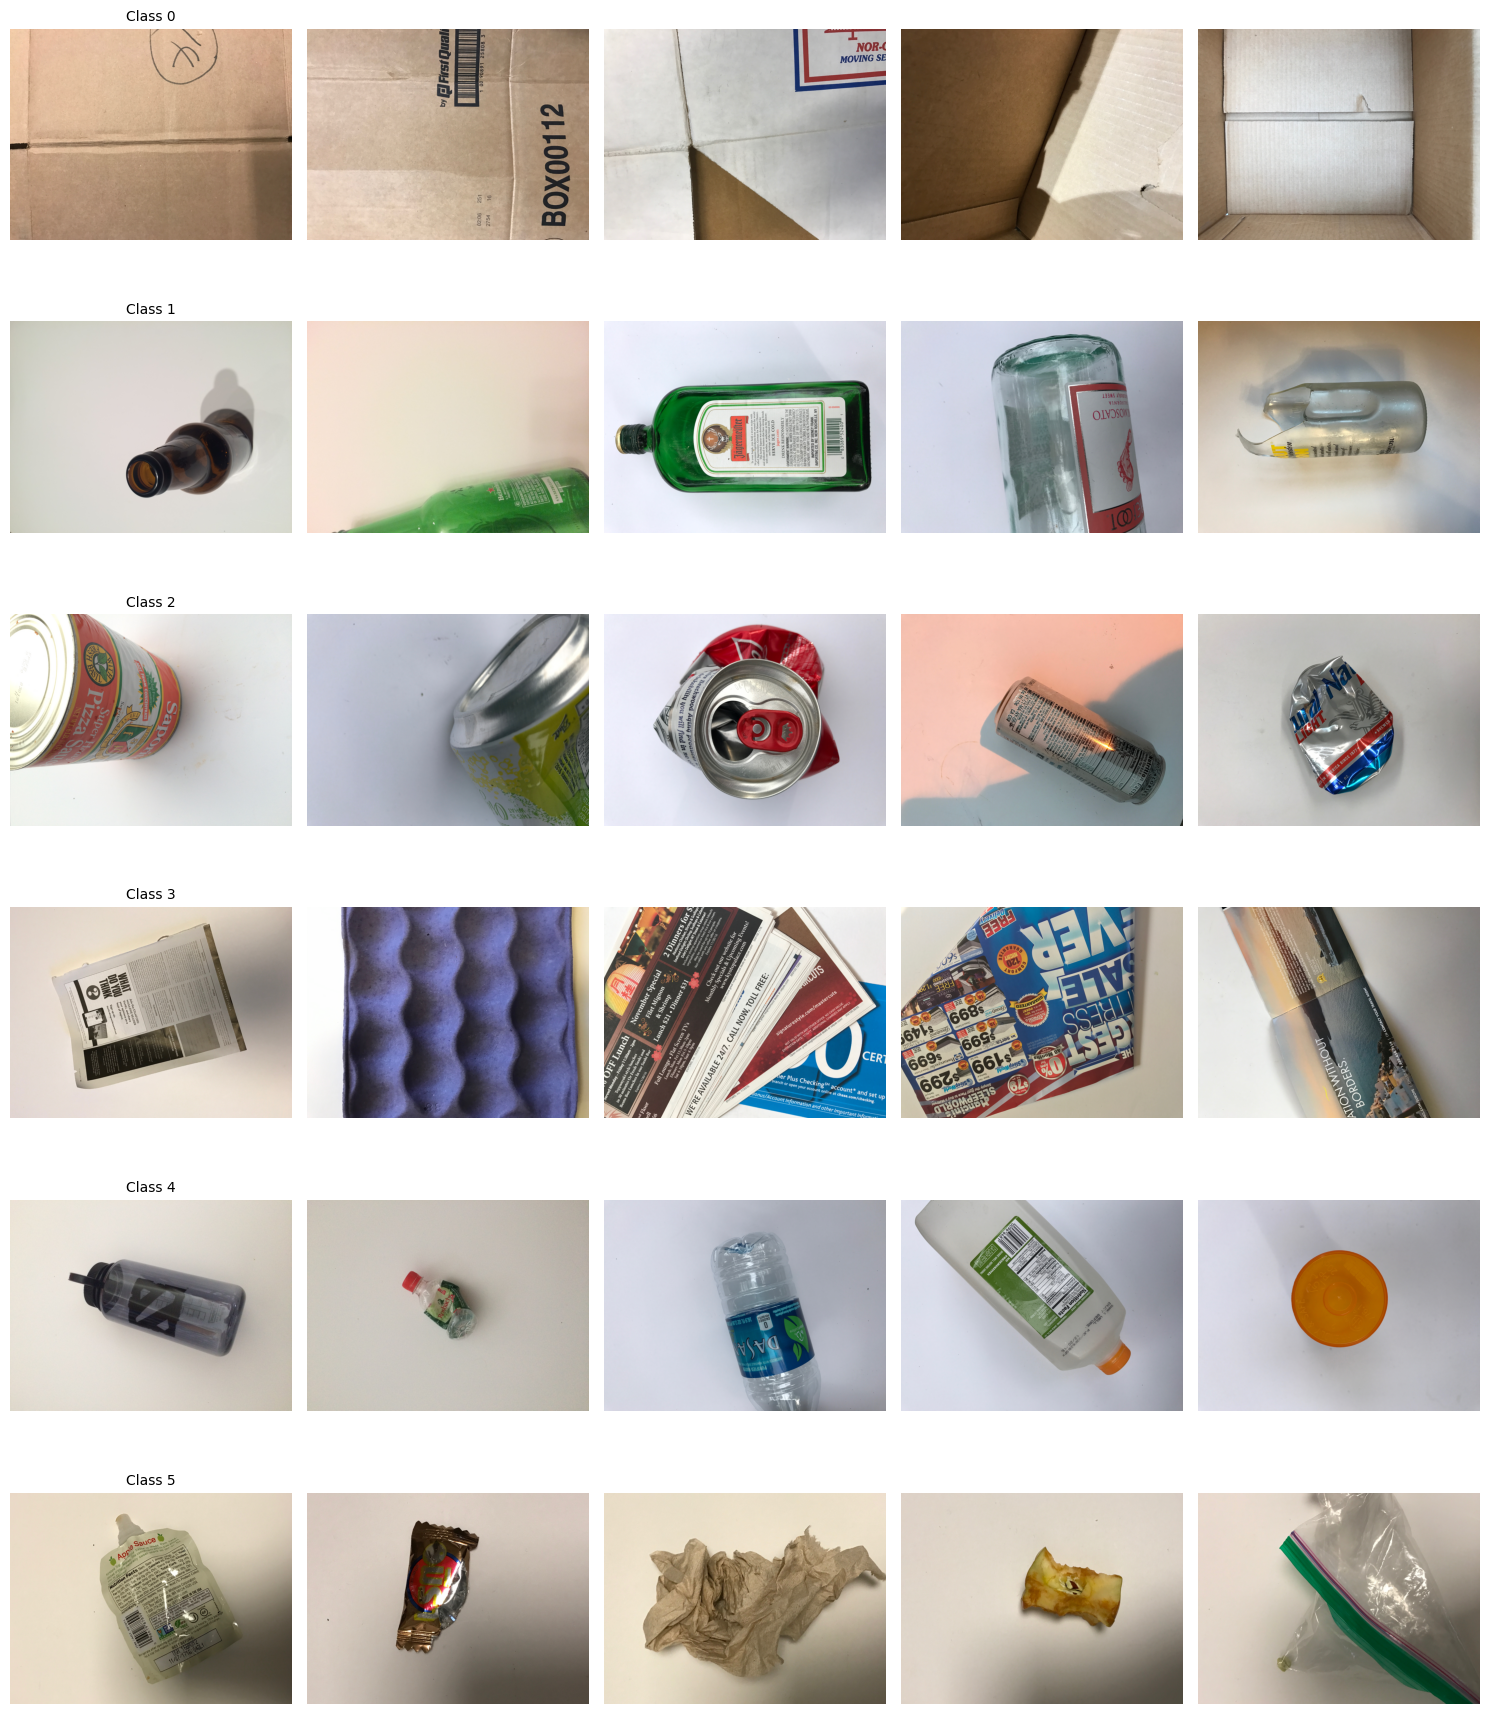

In [61]:
# Display sample images for each class
def display_samples(data, num_samples=5):
    classes = data['label'].unique()
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(num_samples * 3, len(classes) * 3))
    for idx, class_name in enumerate(classes):
        class_data = data[data['label'] == class_name]
        for j in range(num_samples):
            if j < len(class_data):
                image_path = class_data.iloc[j]['image_path']
                img = Image.open(image_path)
                axes[idx, j].imshow(img)
                axes[idx, j].axis('off')
                if j == 0:
                    axes[idx, j].set_title(f'Class {class_name}', fontsize=10)
    plt.tight_layout()
    plt.show()

display_samples(data)

Dari hasil show sample data berdasarkan label, kita dapat mengetahui bahwa **label 5** merupakan label dataset yang memang sebenarnya kumpulan dataset dari label 1-4 (materialnya mirip) ditambah dengan dataset gambar sampah lainnya tapi dengan bentuk yang tidak teratur / random

##  Dimensions Analysis

In [63]:
# Analyze the dimensions of images
dimensions = []
for path in data['image_path']:
    with Image.open(path) as img:
        dimensions.append(img.size)

dimensions_df = pd.DataFrame(dimensions, columns=['Width', 'Height'])
dimensions_df

Width  Height
0      4032    3024
1      4032    3024
2      4032    3024
3      4032    3024
4      4032    3024
...     ...     ...
5049    512     384
5050    512     384
5051    512     384
5052    512     384
5053    512     384

[5054 rows x 2 columns]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


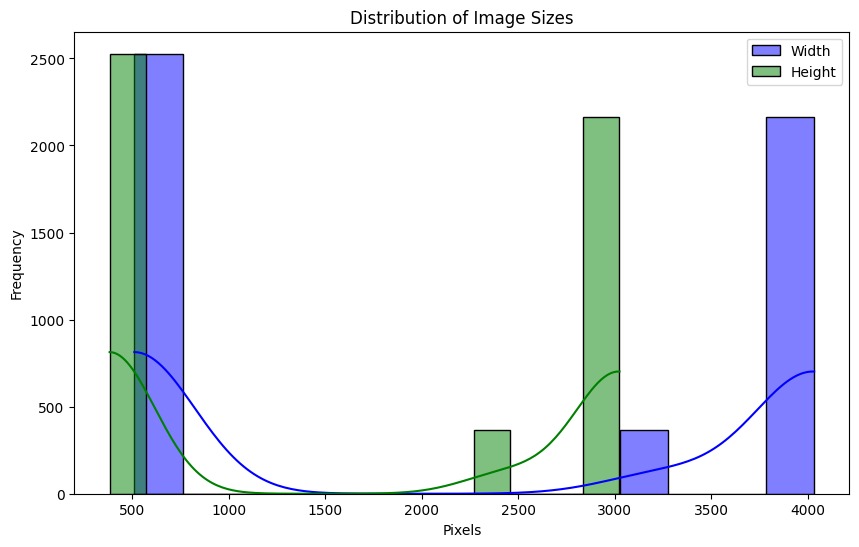

In [67]:
# Plotting distribution of image sizes
plt.figure(figsize=(10, 6))
sns.histplot(data=dimensions_df['Width'], color='blue', label='Width', kde=True)
sns.histplot(data=dimensions_df['Height'], color='green', label='Height', kde=True)
plt.title('Distribution of Image Sizes')
plt.xlabel('Pixels')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Dari hasil visualisasi persebaran size gambar pada dataset, kita dapat melihat bahwa ternyata persebaran seizenya cenderung monoton yang artinya banyak gambar-gambar pada dataset kemungkinan memiliki size yang seragam pada beberapa kelompok ukuran

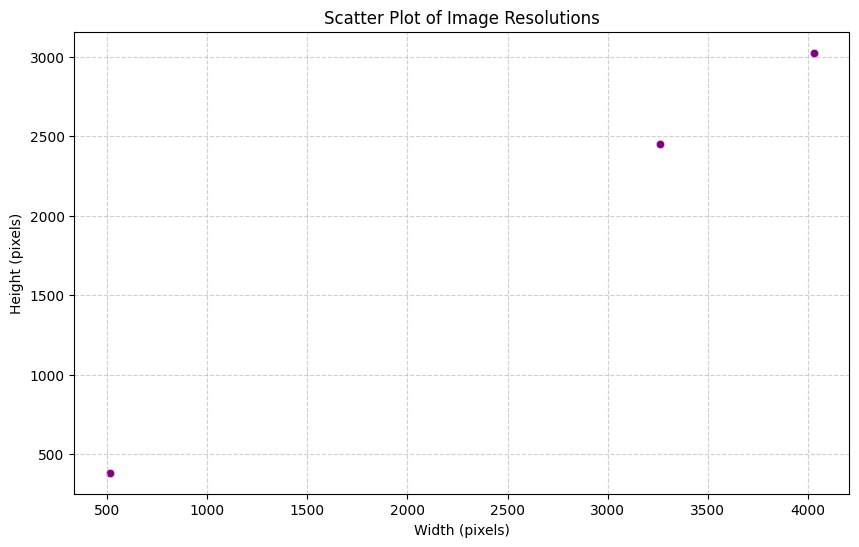

In [70]:
# Scatter plot of image resolutions
plt.figure(figsize=(10, 6))
sns.scatterplot(data=dimensions_df, x='Width', y='Height', alpha=0.7, color='purple')
plt.title('Scatter Plot of Image Resolutions')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Visualisasi image resolution ini membuktikan pernyataan sebelumnya, ternyata hanya ada 3 kelompok resolusi gambar (3 titik)

## Color distribution analysis

Processing images: 100%|██████████| 5054/5054 [06:07<00:00, 13.77it/s] 
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


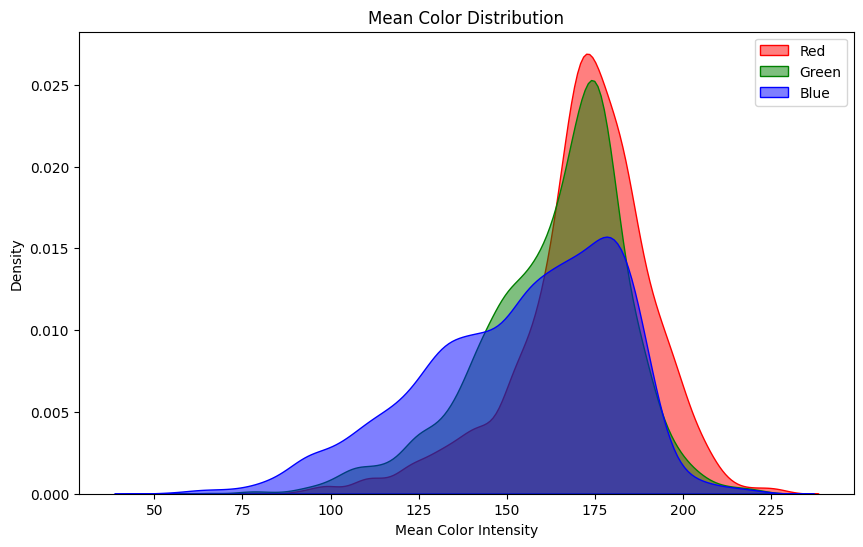

In [75]:
# Function to calculate mean color values
def calculate_mean_colors_simple(path):
    try:
        with Image.open(path) as img:
            img = img.convert('RGB')  # Ensure it's in RGB mode
            img_array = np.array(img)
            red_mean = img_array[:, :, 0].mean()
            green_mean = img_array[:, :, 1].mean()
            blue_mean = img_array[:, :, 2].mean()
            return red_mean, green_mean, blue_mean
    except Exception as e:
        return None

# Process all images in a loop with progress tracking
mean_colors = {'Red': [], 'Green': [], 'Blue': []}
for path in tqdm(data['image_path'], desc="Processing images"):
    result = calculate_mean_colors_simple(path)
    if result:
        mean_colors['Red'].append(result[0])
        mean_colors['Green'].append(result[1])
        mean_colors['Blue'].append(result[2])

# Plot the mean color distribution with matching curve and label colors
plt.figure(figsize=(10, 6))
color_mapping = {'Red': 'red', 'Green': 'green', 'Blue': 'blue'}

for color, values in mean_colors.items():
    sns.kdeplot(values, label=color, fill=True, alpha=0.5, color=color_mapping[color])

plt.title('Mean Color Distribution')
plt.xlabel('Mean Color Intensity')
plt.ylabel('Density')
plt.legend()
plt.show()

Distribusi Warna Dominan:

1. Warna merah memiliki distribusi puncak tertinggi dalam dataset. Hal ini mencerminkan bahwa banyak gambar yang memiliki objek atau latar belakang dengan dominasi warna hangat, seperti plastic atau paper, yang sering kali memiliki warna cerah.
Warna biru menunjukkan distribusi yang lebih lebar, kemungkinan besar berasal dari bahan seperti glass atau pantulan cahaya pada metal.
Warna hijau memiliki distribusi yang lebih rendah, mungkin berasal dari cardboard atau material alami lainnya yang sering muncul dalam dataset.

2. Hubungan dengan Total Data pada Setiap Label:


* Paper (1200an gambar): Dominasi warna merah terlihat konsisten dengan kategori ini, karena kertas sering kali memiliki warna yang lebih cerah atau kehangatan tertentu.
* Plastic (1000an gambar): Warna merah juga banyak terdapat pada plastik, terutama jenis plastik berwarna terang.
* Glass (800an gambar): Warna biru lebih dominan pada kategori ini, sesuai dengan sifat reflektif atau transparan dari kaca yang dapat memantulkan cahaya.
* Metal (600an gambar): Distribusi warna cenderung biru atau abu-abu, mencerminkan bahan logam yang sering kali memiliki permukaan yang bersinar atau memantulkan cahaya.
* Cardboard (800an gambar): Cenderung memiliki dominasi warna hijau yang lebih rendah, karena material kardus biasanya berwarna kecokelatan.
* Trash (200an gambar): Distribusi warnanya kemungkinan lebih bervariasi, tergantung pada jenis sampahnya, tetapi dengan dominasi intensitas yang lebih rendah karena materialnya sering kali tidak mencolok.


3. Implikasi untuk Model Klasifikasi:

* Dominasi warna tertentu pada label dengan jumlah data yang besar, seperti paper dan plastic, dapat mempermudah model untuk belajar mengenali kategori ini.
* Kategori dengan jumlah data lebih kecil, seperti trash, yang juga memiliki distribusi warna yang tidak spesifik, mungkin menjadi lebih sulit untuk dikenali oleh model.
* Variasi distribusi warna dan ketidakseimbangan jumlah data pada label memerlukan teknik class weight atau augmentasi data atau penyeimbangan kelas agar model dapat mengenali semua kategori dengan baik.


/tmp/ipykernel_30/2795024069.py:55: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_hist = plt.subplot(2, 1, 1)  # First row for the histogram


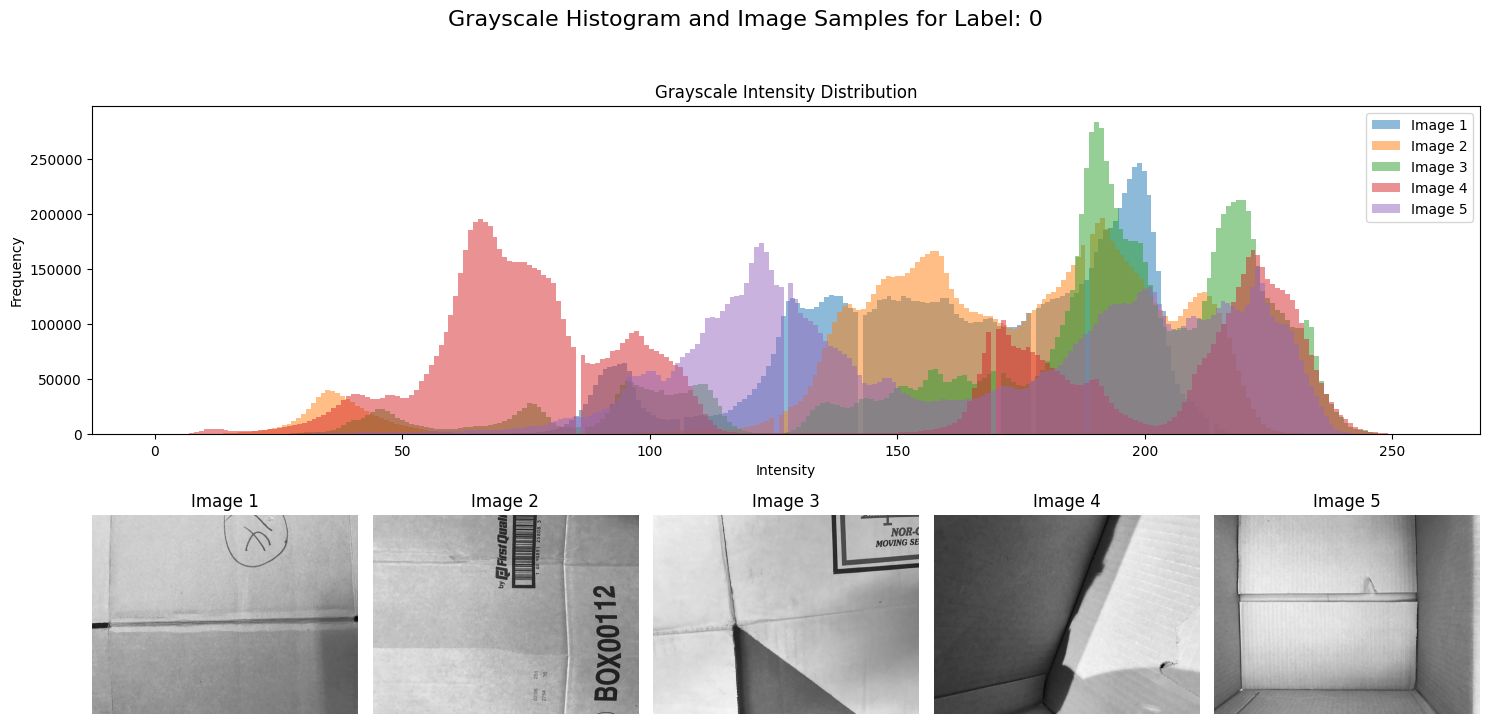

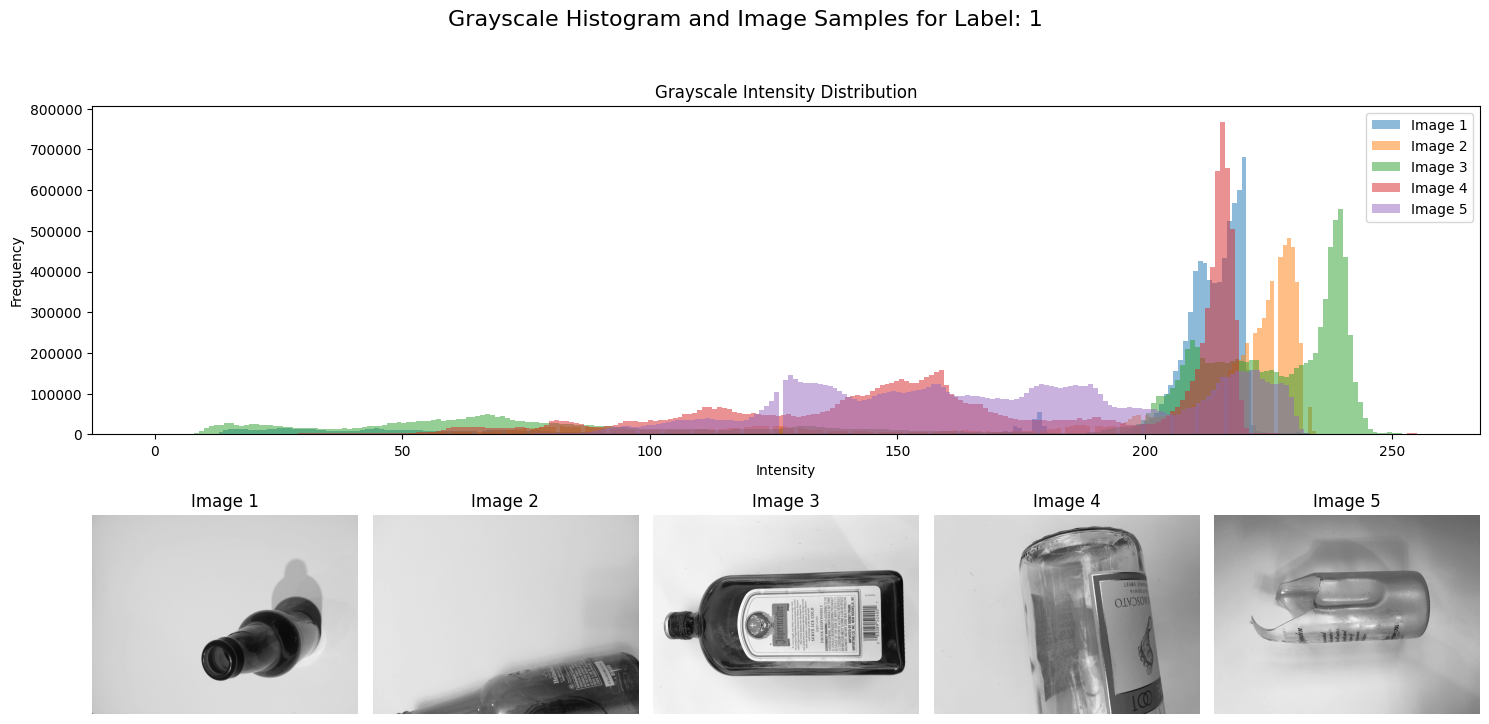

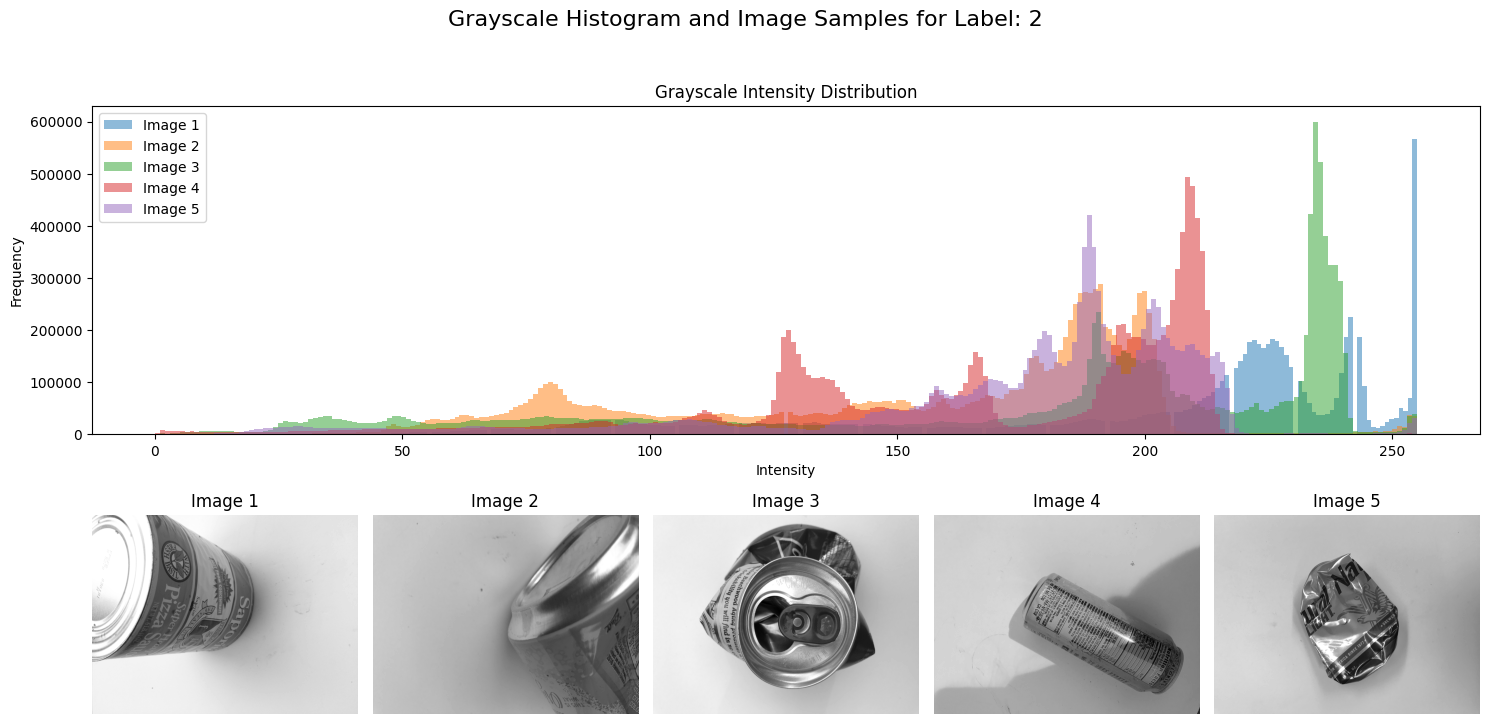

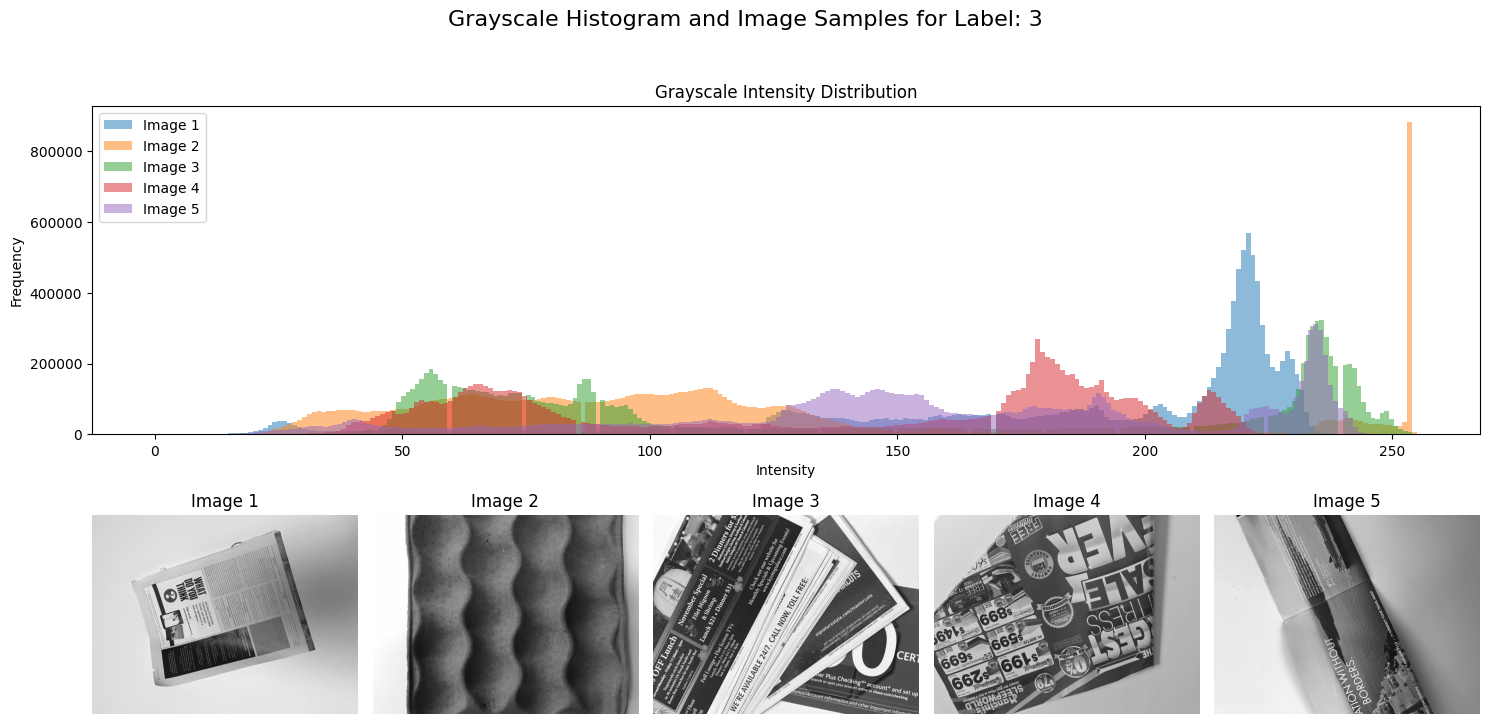

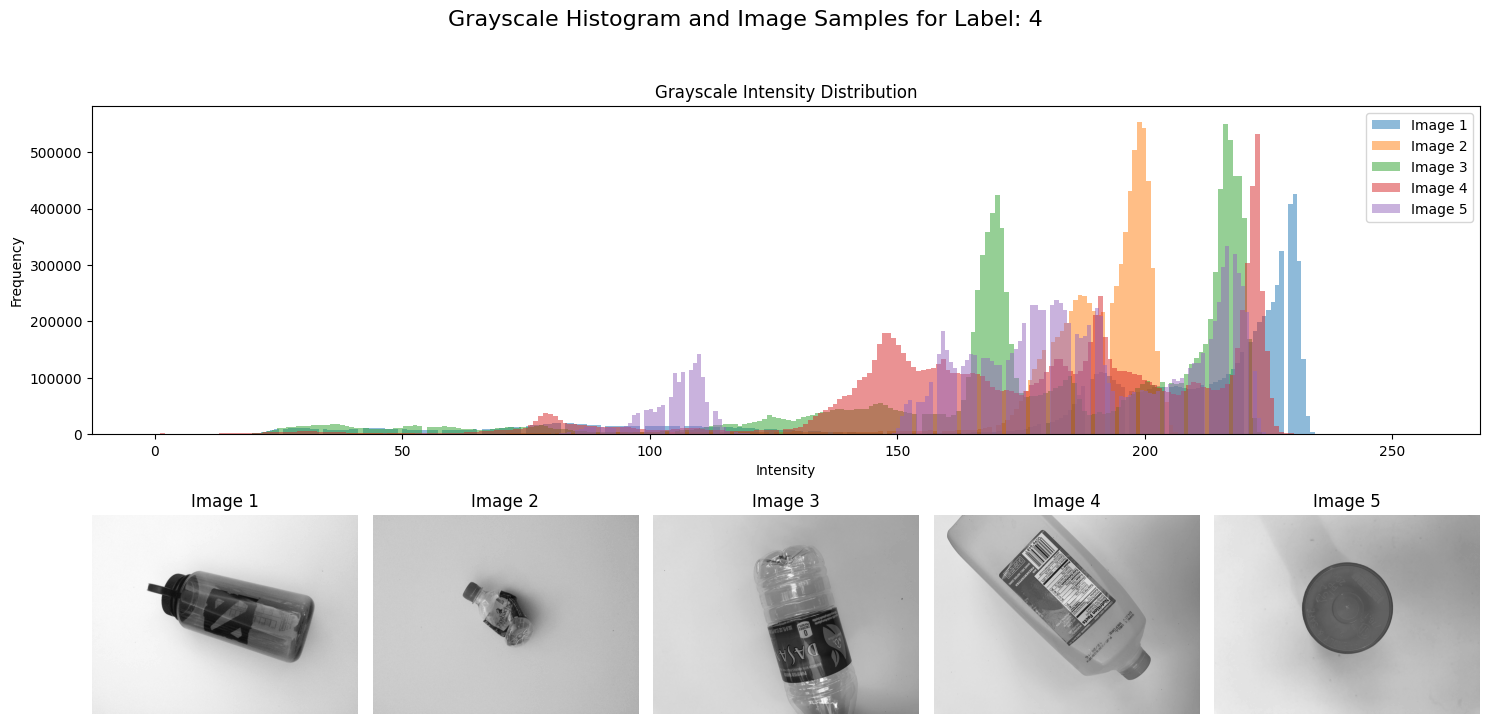

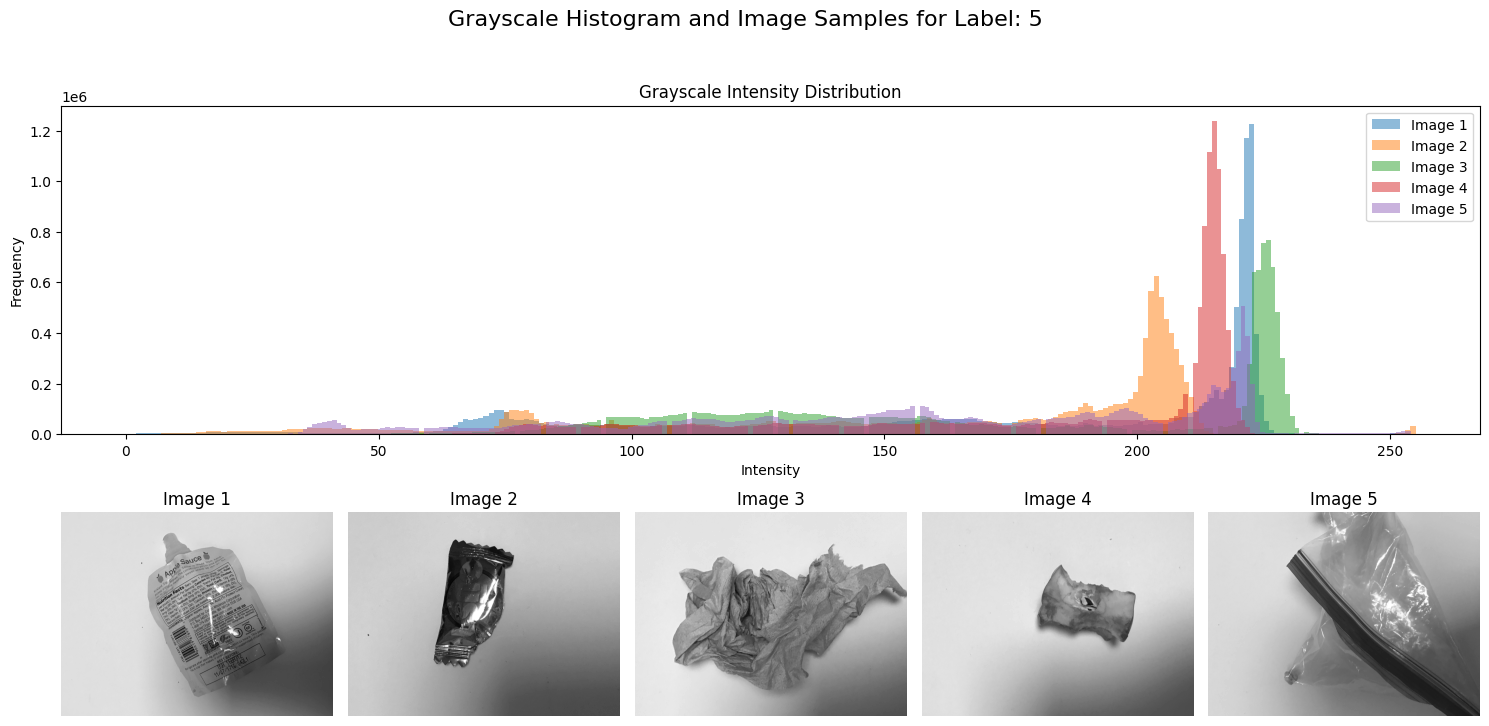

In [81]:
# Texture analysis using grayscale intensity histogram
def plot_grayscale_histogram_and_images_per_label(data, label_column='label', num_samples=5):
    unique_labels = data[label_column].unique()  

    for label in unique_labels:
        # Filter images for the current label
        label_images = data[data[label_column] == label]['image_path'].head(num_samples)

        # Create a new figure for each label
        fig, axes = plt.subplots(2, max(num_samples, 3), figsize=(15, 8))  # Ensures enough space
        fig.suptitle(f"Grayscale Histogram and Image Samples for Label: {label}", fontsize=16)

        # Subplot for the histograms (row 1, spans all columns)
        ax_hist = plt.subplot(2, 1, 1)  # First row for the histogram
        for i, path in enumerate(label_images):
            try:
                with Image.open(path) as img:
                    gray_img = img.convert("L")  # Convert to grayscale
                    gray_array = np.array(gray_img)
                    ax_hist.hist(
                        gray_array.ravel(), bins=256, color=f"C{i}", alpha=0.5, label=f"Image {i+1}"
                    )
            except Exception as e:
                print(f"Error processing image {path}: {e}")
        
        ax_hist.set_title("Grayscale Intensity Distribution")
        ax_hist.set_xlabel("Intensity")
        ax_hist.set_ylabel("Frequency")
        ax_hist.legend()

        # Subplots for displaying all sampled images (row 2)
        for i, path in enumerate(label_images):
            ax_img = plt.subplot(2, num_samples, num_samples + i + 1)
            try:
                with Image.open(path) as img:
                    gray_img = img.convert("L")
                    ax_img.imshow(gray_img, cmap="gray")
                    ax_img.axis("off")
                    ax_img.set_title(f"Image {i+1}")
            except Exception as e:
                print(f"Error displaying image {path}: {e}")

        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title
        plt.show()

# Call the function on the dataset
plot_grayscale_histogram_and_images_per_label(data, label_column='label', num_samples=5)

### Label 0 (Cardboard)
- Distribusi grayscale untuk label ini kemungkinan menunjukkan intensitas warna yang lebih datar dan cenderung ke arah medium (tidak terlalu terang atau gelap).
- Sesuai dengan sifat visual kardus yang memiliki tekstur matte dan warna coklat netral

### Label 1 (Glass)
- Grayscale untuk kaca bisa menunjukkan variasi dari terang (karena pantulan cahaya) ke gelap (bayangan atau kaca berwarna).
- Puncak intensitas cenderung lebih tinggi karena efek pantulan dari permukaan kaca.

### Label 2 (Metal)
- Intensitas grayscale dari gambar metal biasanya bervariasi tajam.
- Area sangat terang akibat refleksi cahaya.
- Area gelap di bayangan atau permukaan buram.

### Label 3 (Paper)
- Distribusi grayscale untuk kertas cenderung stabil pada nilai medium hingga tinggi karena warna putih atau terang yang dominan.
- Variasi tekstur seperti tulisan atau noda bisa menciptakan sedikit deviasi dalam distribusi.

### Label 4 (Plastic)
- Plastik dapat memiliki distribusi grayscale yang cukup luas, bergantung pada warnanya (bening, putih, atau warna cerah lainnya).
- Plastik bening dapat memiliki distribusi intensitas yang menyerupai kaca tetapi lebih seragam.

### Label 5 (Trash)
- Sampah mencakup berbagai material dengan tekstur dan warna yang berbeda.
- Distribusi grayscale-nya kemungkinan menunjukkan variasi terbesar dibandingkan label lainnya.
- Puncaknya bisa lebih datar karena keragaman material.


# Data Pre-processing

In [19]:
# Create output directories for train, test, and validation sets
output_path = "output"
os.makedirs(output_path, exist_ok=True)
for split in ['train', 'test', 'validation']:
    split_path = os.path.join(output_path, split)
    os.makedirs(split_path, exist_ok=True)
    for class_name in data['label'].unique():
        os.makedirs(os.path.join(split_path, str(class_name)), exist_ok=True)

# Split data and copy images to respective directories
def copy_images(dataframe, split, class_name):
    """Copy images into respective directories based on split."""
    for _, row in dataframe.iterrows():
        src = row['image_path']
        dst = os.path.join(output_path, split, str(class_name), os.path.basename(src))
        
        if not os.path.exists(src):
            print(f"Warning: {src} does not exist.")
            continue
        
        shutil.copy(src, dst)

# Split dataset into train, validation, and test
for class_name in data['label'].unique():
    class_data = data[data['label'] == class_name]
    train_data, test_val_data = train_test_split(class_data, test_size=0.3, random_state=42)
    test_data, val_data = train_test_split(test_val_data, test_size=0.5, random_state=42)

    # Copy files to train, test, and validation directories
    copy_images(train_data, 'train', class_name)
    copy_images(test_data, 'test', class_name)
    copy_images(val_data, 'validation', class_name)

# Define parameters
image_size = (224, 224)
batch_size = 16

# Define a function to preprocess images
def preprocess_image(file_path, label):
    """Preprocess images: validate, decode, resize, and normalize."""
    if not tf.io.gfile.exists(file_path):
        raise ValueError(f"File {file_path} does not exist.")
    
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

# Define a function for data augmentation
def data_augmentation(image):
    """Apply data augmentation: flip, rotation, scaling, and brightness."""
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image

# Define a function to load datasets
def create_dataset(directory):
    """Create a dataset using `image_dataset_from_directory`."""
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        labels="inferred",
        label_mode="int",  # 'int' for sparse labels
        image_size=image_size,
        batch_size=batch_size
    )
    # Apply augmentations and prefetch for efficiency
    dataset = dataset.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Build train, validation, and test datasets
train_dataset = create_dataset(os.path.join(output_path, 'train'))
validation_dataset = create_dataset(os.path.join(output_path, 'validation'))
test_dataset = create_dataset(os.path.join(output_path, 'test'))

# Get the total number of images in each set
total_train = sum(1 for _ in train_dataset)
total_val = sum(1 for _ in validation_dataset)
total_test = sum(1 for _ in test_dataset)

# Print dataset statistics
print("Total Train Images:", total_train * batch_size)
print("Total Validation Images:", total_val * batch_size)
print("Total Test Images:", total_test * batch_size)

Found 2307 files belonging to 6 classes.
Found 712 files belonging to 6 classes.
Found 707 files belonging to 6 classes.
Total Train Images: 2320
Total Validation Images: 720
Total Test Images: 720


**Penjelasan**

1. Pembuatan Direktori Output:

    - Membuat struktur folder untuk menyimpan data pelatihan, pengujian, dan validasi berdasarkan label kelas.
    - Direktori untuk setiap split (train, test, validation) dibuat sesuai label yang ditemukan dalam dataset.
    - Fungsi copy_images:
    - Bertugas menyalin gambar ke direktori yang sesuai (train, test, validation).
    - Memvalidasi keberadaan file gambar sebelum menyalinnya untuk menghindari error.

2. Pembagian Dataset:

    - Data setiap kelas dipisah menjadi tiga bagian:
    - Train: 70% data.
    - Test: 15% data.
    - Validation: 15% data.
    - Pembagian dilakukan dengan train_test_split, menjaga distribusi random yang dapat direproduksi dengan random_state.

3. Parameter dan Preprocessing:

    - Parameter: Gambar diubah ukurannya menjadi 224x224, dengan batch size 16.
    - Preprocessing: Gambar dibaca, divalidasi keberadaannya, di-decode ke format RGB, diresize, dan dinormalisasi menggunakan preprocessor MobileNetV2.

4. Augmentasi Data:

    - Fungsi data_augmentation menambahkan variasi pada data untuk meningkatkan generalisasi model, termasuk:
    - Flip horizontal dan vertical.
    - Kontras acak.
    - Kecerahan acak.

5. Pembuatan Dataset:

    - Menggunakan image_dataset_from_directory untuk membuat dataset dari struktur folder.
    - Dataset dilabel otomatis berdasarkan nama folder.
    - Augmentasi diterapkan dengan map dan efisiensi ditingkatkan menggunakan prefetch.

6. Membangun Dataset:

    - Dataset untuk pelatihan, validasi, dan pengujian dibuat berdasarkan direktori train, validation, dan test.
    - Total gambar di setiap dataset dihitung.

7. Statistik Dataset:
    - Menampilkan jumlah total gambar dalam setiap split (train, validation, test) untuk memastikan pembagian dataset berhasil.

**Kelebihan Kode:**
- Struktur Folder Rapi: Memisahkan data berdasarkan split dan label.  
- Validasi File: Memeriksa file corrupt atau tidak ditemukan.
- Augmentasi Beragam: Menambahkan variasi pada data untuk mencegah overfitting.
- Efisiensi: Menggunakan prefetch untuk mempercepat pemrosesan data.
- Fleksibilitas: Dataset dibangun langsung dari folder tanpa memindahkan file asli.

**Kekurangan Kode:**
- Peningkatan Penyimpanan: Salinan file membutuhkan lebih banyak ruang disk.
- Tidak Memanfaatkan TFRecord: Menggunakan file individual kurang efisien dibandingkan TFRecord untuk dataset besar.
- Augmentasi Dapat Ditingkatkan: Belum ada rotasi atau scaling.
- Distribusi Tidak Terkontrol: Tidak ada pengecekan keseimbangan antar kelas setelah split.
- Penghitungan Gambar Tidak Akurat: Total gambar dihitung berdasarkan batch size, sehingga hasilnya bisa sedikit meleset jika batch tidak penuh.

In [21]:
def calculate_class_weights_from_data(data):
    labels = data['label'].values  
    unique_classes = np.unique(labels)  
    class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=labels)
    
    return {cls: weight for cls, weight in zip(unique_classes, class_weights)}

class_weights = calculate_class_weights_from_data(data)
class_weights

{0: 1.0450785773366418,
 1: 0.8406520292747838,
 2: 1.0272357723577237,
 3: 0.7090347923681257,
 4: 0.873789764868603,
 5: 3.0742092457420926}

Class weight akan digunakan dalam pembobotan kelas ketika fitting model pada dataset yang tidak imbalance  
Formula class_weight='balanced': Menghitung bobot untuk setiap kelas dengan formula:

$ \text{weight}_c = \frac{\text{total samples}}{\text{number of classes} \times \text{samples in class } c} $
​
 
Dengan cara ini, kelas dengan jumlah sampel lebih sedikit mendapatkan bobot lebih tinggi.

Distribusi Bobot Kelas:
* Kelas 0 (Cardboard): Bobot 1.045 menunjukkan bahwa jumlah sampel untuk kelas ini cukup dekat dengan rata-rata, meskipun sedikit di bawah kelas dengan jumlah sampel dominan.
* Kelas 1 (Glass): Bobot 0.841 menunjukkan bahwa jumlah sampel untuk kelas ini cukup banyak dibandingkan rata-rata, sehingga memiliki bobot lebih rendah.
* Kelas 2 (Metal): Bobot 1.027 menunjukkan kelas ini memiliki jumlah sampel mendekati rata-rata.
* Kelas 3 (Paper): Bobot 0.709 adalah yang terendah, menunjukkan bahwa kelas ini memiliki jumlah sampel paling banyak, sehingga kontribusinya dalam pelatihan cukup signifikan tanpa perlu pembobotan tambahan.
* Kelas 4 (Plastic): Bobot 0.874 menunjukkan jumlah sampel cukup tinggi, tapi tidak setinggi kelas 3.
* Kelas 5 (Trash): Bobot 3.074 adalah yang tertinggi, menunjukkan bahwa kelas ini memiliki jumlah sampel yang paling sedikit, sehingga membutuhkan pembobotan besar untuk memastikan kontribusinya tidak diabaikan dalam pelatihan model.
.

In [24]:
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb.finish()

# Initialize W&B for MobileNetV3
wandb.init(project="trash-image-classification", name="FineTune-MobileNetV3", config={"epochs": 100})

wandb: Currently logged in as: dzalhaqi (dzal). Use `wandb login --relogin` to force relogin


In [ ]:
total_epochs = 100

# Define the MobileNetV3 model
base_model = tf.keras.applications.MobileNetV3Large(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# Freeze the bottom layers
for layers in base_model.layers[:-6]:
    layers.trainable = False

# Add custom layers
last_output = base_model.layers[-1].output
x = tf.keras.layers.GlobalAveragePooling2D()(last_output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(
        128, 
        activation='elu', 
        kernel_initializer='glorot_uniform',
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    )(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(len(classes), activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint(filepath="MobileNetV3_best_model.keras", monitor='val_loss', save_best_only=True, verbose=1)
callbacks = [
    early_stopping, 
    lr_scheduler, 
    model_checkpoint, 
    WandbMetricsLogger(),
    WandbModelCheckpoint(
        "MobileNetV3-Models.keras",
        save_best_only=True,
        verbose=1,
        save_freq="epoch",
        mode="min"
    )
],

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=total_epochs,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


Epoch 1/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.2939 - loss: 2.4322
Epoch 1: val_loss improved from inf to 1.40142, saving model to MobileNetV3_best_model.keras

Epoch 1: val_loss improved from inf to 1.40142, saving model to MobileNetV3-Models.keras
145/145 ━━━━━━━━━━━━━━━━━━━━ 55s 295ms/step - accuracy: 0.2944 - loss: 2.4300 - val_accuracy: 0.5478 - val_loss: 1.4014 - learning_rate: 1.0000e-04
Epoch 2/100
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.5447 - loss: 1.5431
Epoch 2: val_loss improved from 1.40142 to 1.11502, saving model to MobileNetV3_best_model.keras

Epoch 2: val_loss improved from 1.40142 to 1.11502, saving model to MobileNetV3-Models.keras
145/145 ━━━━━━━━━━━━━━━━━━━━ 37s 257ms/step - accuracy: 0.5449 - loss: 1.5423 - val_accuracy: 0.6685 - val_loss: 1.1150 - learning_rate: 1.0000e-04
Epoch 3/100
144/145 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.6502 - loss: 1.2292
Epoch 3: val_loss improved from 1.11502 to 0.96473, saving mode

In [27]:
# Finish the W&B run
wandb.finish()

1. Model:
    - Menggunakan MobileNetV3Large (transfer learning, ImageNet).
    - Freeze sebagian besar lapisan, hanya melatih 6 lapisan terakhir.
    - Tambahan: pooling global, normalisasi, dropout, dan dense layer.
    
2. Kompilasi:
    - Loss: Sparse Categorical Crossentropy.
    - Optimizer: Adamax.
    - Metrik: Akurasi.

3. Callbacks:
    - EarlyStopping: Mencegah overfitting.
    - ReduceLROnPlateau: Adaptasi learning rate otomatis.
    - ModelCheckpoint: Simpan model terbaik.
    - Integrasi Weights & Biases.

4. Pelatihan:
    - Epoch: 100 (berhenti lebih awal jika validasi stagnan).
    - Dataset: Pelatihan, validasi, dan class_weights untuk data imbalance.

**Kelebihan:**
- Efisien: Memanfaatkan transfer learning.
- Stabil: Regularisasi, dropout, dan adaptasi learning rate.
- Monitoring: Callback terintegrasi dengan logging.

Kekurangan:
- Kompleksitas: Butuh konfigurasi hyperparameter lebih banyak.
- Ketergantungan Pre-trained: Bergantung pada bobot ImageNet.
- Overhead: W&B bisa menambah latensi.

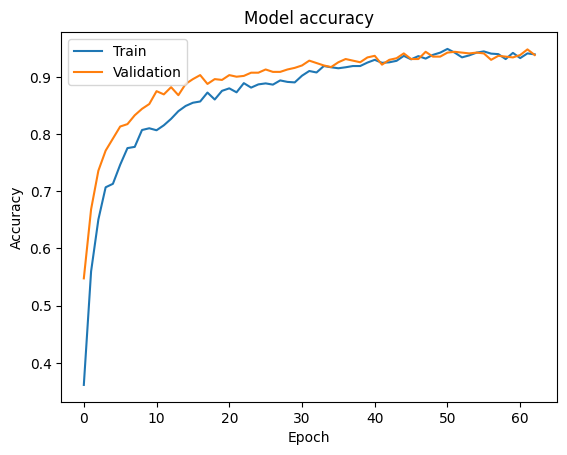

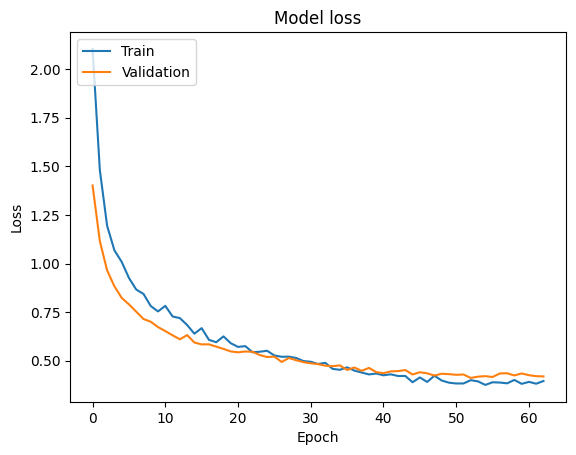

In [28]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [30]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Get predictions for the test dataset
y_pred_probs = model.predict(test_dataset, verbose=1)  # Probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Get true labels from the test dataset
y_true = np.concatenate([y for _, y in test_dataset], axis=0)  # Extract ground truth

# Generate and display the classification report
class_names = [str(c) for c in classes]
class_report = classification_report(y_true, y_pred, target_names=class_names) 
print("\nClassification Report:\n")
print(class_report)

45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 265ms/step - accuracy: 0.9327 - loss: 0.4470
Test Loss: 0.42548245191574097
Test Accuracy: 0.9335219264030457
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 233ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.18      0.18      0.18       109
           1       0.22      0.21      0.22       137
           2       0.24      0.26      0.25       116
           3       0.18      0.17      0.18       167
           4       0.16      0.16      0.16       139
           5       0.00      0.00      0.00        39

    accuracy                           0.18       707
   macro avg       0.16      0.16      0.16       707
weighted avg       0.18      0.18      0.18       707



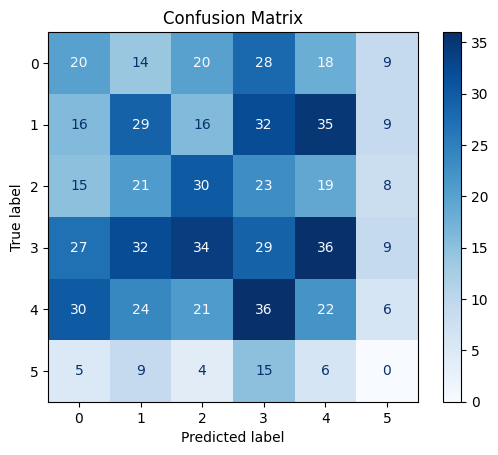

In [31]:
conf_matrix = confusion_matrix(y_true, y_pred)

# Display the confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [32]:
# Save the model in Keras format (.keras)
model.save("MobileNetV3_trash_classifier.keras") 

model_dir = "/kaggle/working/MobileNetV3_trash_classifier_directory"

# Create the directory if it doesn't exist
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Move the .keras model file into the directory
shutil.move("MobileNetV3_trash_classifier.keras", model_dir)

'/kaggle/working/MobileNetV3_trash_classifier_directory/MobileNetV3_trash_classifier.keras'

In [ ]:
upload_folder(
    folder_path="/kaggle/working/MobileNetV3_trash_classifier_directory",
    repo_id="dzal/trash-classification",  
    commit_message="Initial commit of MobileNetV3 model",
    use_auth_token="ACCESS_TOKEN", 
)

MobileNetV3_trash_classifier.keras:   0%|          | 0.00/16.6M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/dzal/trash-classification/commit/60a9de2a88fd3239a86fbf11c7aa1639f90cfdb1', commit_message='Initial commit of MobileNetV3 model', commit_description='', oid='60a9de2a88fd3239a86fbf11c7aa1639f90cfdb1', pr_url=None, repo_url=RepoUrl('https://huggingface.co/dzal/trash-classification', endpoint='https://huggingface.co', repo_type='model', repo_id='dzal/trash-classification'), pr_revision=None, pr_num=None)

# Final Result

## Kesimpulan

Dari hasil pemodelan diketahui bahwa model classification yang dibangun masih mengalami overfitting yang dapat dilihat dari tingginya akurasi saat training tetapi sangat rendah ketika testing dan juga ditandai oleh beberapa metrik lain pada classification yang memang lebih sesuai untuk data imbalance (seperti f1 score, recall, dan precission yang mana untuk case data trash seperti ini memang lebih baik menggunakan f1 socre).

Overfitting pada model masih terjadi bahkan ketika sudah menggunakan beberapa teknik dalam menangani permasalahan imbalance dataset (seperti penggunaan augmentasi dasar, class weight, penggunaan dropout dan batch normalization layer) sebagaimana yang diketahui pada exploratory image analysis. Pada dasarnya penyebab overfitting itu ada berapa hal seperti:
1. Model Terlalu Kompleks: Terlalu banyak parameter membuat model mempelajari noise.
2. Dataset Kecil: Data pelatihan kurang variatif, model jadi "menghafal".
3. Kurang Regularisasi: Tidak menggunakan dropout, weight decay, atau batch normalization.
4. Data Tidak Seimbang: Model memprioritaskan kelas mayoritas, performa kelas minoritas rendah.
5. Augmentasi Minim: Kurangnya variasi augmentasi membuat model kurang generalisasi.
6. Validasi Tidak Representatif: Pembagian data yang salah menyebabkan hasil validasi bias.

## Saran

Untuk menghindari overfitting pada saat pemodelan kita bisa melakukan beberapa hal seperti
1. Menggunakan teknik augmentasi data yang lebih beragam (rotasi, zoom, crop, brightness).
2. Mengatur model dengan kompleksitas yang sesuai dengan ukuran dataset.
3. Menggunakan regularisasi seperti L1/L2 regularization atau dropout.
4. Melakukan resampling atau weight balancing untuk menangani ketidakseimbangan data.
5. Menerapkan early stopping untuk menghentikan pelatihan saat performa validasi mulai menurun.
6. Memastikan validasi dilakukan dengan pembagian dataset yang benar (stratified split jika perlu).